# Experimental data and simulations
# Convex hull as diagnostic tool in single-molecule localization microscopy

In [1]:
import numpy as np
import locan as lc
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import importlib
import py_files.simulations as si
import py_files.cluster_properties as cp
import py_files.standard_deviation_determination as stdd
importlib.reload(cp)
importlib.reload(si)
from scipy.stats import gamma
from py_files.matplotlib_custom import second_axis_log, second_axis


import colorcet as cc
import boost_histogram as bh
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Find the parameters of the gamma distribution underlying the experimental intensity values

In [2]:
exp_path = r"Experimental data\CD45_647_7_roi_0.yaml"
roi = lc.Roi.from_yaml(exp_path)
roi.reference.file_path = r"Experimental data\CD45_647_7.txt"
locdata = roi.locdata()
condition = "0 < frame < 15000 and 0 < intensity and local_background < 1200"
locdata = lc.select_by_condition(locdata, condition=condition)
locdata.reduce();

samples_exp = locdata.coordinates
clust_labels_exp = DBSCAN(eps=25, min_samples=3).fit_predict(samples_exp)
_, sample_count_exp, area_chs_exp, _ = cp.cluster_property(clust_labels_exp, samples_exp)

experimental_data = np.concatenate(([sample_count_exp], [area_chs_exp]))  # for 2D histogram

intensities = locdata.data["intensity"].to_numpy()
intensity_mean = np.mean(intensities)
intensity_min = np.min(intensities)
intensity_max = np.max(intensities)
print("the mean intensity is {:.2f}".format(intensity_mean))
print("the minimum intensity is {:.2f}".format(intensity_min))
print("the maximum intensity is {:.2f}".format(intensity_max))

the mean intensity is 21738.64
the minimum intensity is 8001.07
the maximum intensity is 142315.00


In the following it is attempted to fit a gamma distribution starting at x = 0 to the truncated experimental values starting at x = 8001. This is simply done but trying out different combinations of a and scale until the truncated drawn values in the histogram are similar to the experimental data displayed as probability density.

In [3]:
gamma_a = 1.1
rvs_gamma = gamma.rvs(a=gamma_a, loc=0, scale=11000, size=1000000)
rvs_gamma_mean = np.mean(rvs_gamma)
print("the mean of the underlying non-truncated gamma distribution is {:.2f}".format(rvs_gamma_mean))
rvs_gamma_trunc = rvs_gamma[(rvs_gamma>intensity_min) & (rvs_gamma<intensity_max)]
rvs_gamma_trunc_mean = np.mean(rvs_gamma_trunc) 
print("the mean of the truncated gamma distribution is {:.2f}".format(rvs_gamma_trunc_mean))

the mean of the underlying non-truncated gamma distribution is 12098.37
the mean of the truncated gamma distribution is 19509.46


The mean of the truncated gamma distribution should be similar to the mean of the experimental data. The mean of the non-truncated gamma distribution can later be fed to the simulation.

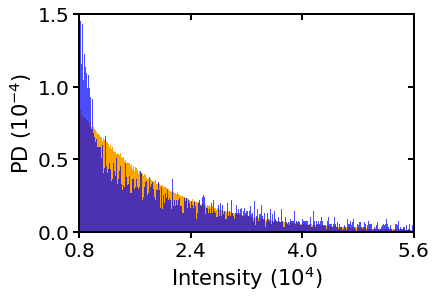

In [4]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))

bins = np.arange(8000, 152000+100, 100)
ax.hist(x=rvs_gamma_trunc, bins=bins, density=True, color="orange")
ax.hist(x=intensities, bins=bins, density=True, color="blue", alpha=0.7)
ax.set_xlim(8000, 56000)
ax.set_xlabel("Intensity (" + r"$10^{4}$" + ")", fontsize=21)
ax.set_ylabel("PD (" + r"$10^{-4}$" + ")", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
num_ticks_x = 4
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks_x))
tick_spacing_y = 0.00005
ax.ticklabel_format(style="sci", axis="both", scilimits=(0,0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.yaxis.get_offset_text().set_visible(False)
ax.xaxis.get_offset_text().set_visible(False)
second_axis(ax, "top", num_ticks=num_ticks_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_ylim(0, 1.5e-4)

fig.savefig(r"Figures\Figure 2\intensities.svg")

## Simulate the experimental data with varying localization precisions depending on the intensities
The localization precision is calculated with $\sigma = \sqrt{\frac{\sigma_{a}^2}{N}(1 + 4 \tau + \sqrt{\frac{2 \tau}{1+4\tau}}}$ with $\sigma_{a}^2 = \sigma_{PSF}^2+\frac{a^2}{12}$ and $\tau = \frac{2\pi\sigma_{a}^2b}{Na^2}$\
$\sigma_{PSF}$ is the standard deviation of the point spread function, i.e. $\sigma_{PSF} = \frac{FWHM}{2\sqrt{2\ln{2}}}$\
$a$ is the pixel size\
$b$ is the background photon count per pixel\
$N$ is the photon count of the localization\
The photon counts can be received with a known digital conversion factor f by $N=\frac{I}{f}$, where $I$ is the measured intensity.


### TODO: 
add $\sqrt{2}$ as a factor to the expression of the localization precision due to the usage of EMCCD cameras (excess noise of the electron multiplication process)?\
add gain factor (not only digital conversion factor) to calculate photon counts? (https://www.nature.com/articles/s41598-021-97759-6) \
Improve gamma distribution fit of intensity values\
What is the exact digital conversion factor of high power setup (Patricks setup)?

In [5]:
factor = 10.5  # 3.5 ?  

intensity_mean = rvs_gamma_trunc_mean
photons_mean = si.intensity_to_photons(intensity_mean, factor)
photons_min = si.intensity_to_photons(intensity_min, factor)

psf_std = si.fwhm_to_std(360)  # PSF can be slightly different in different experiments
photons_background = 100
pixel_size = 120

sim_param = dict(parent_intensity=1e-5, lower_limit=-5300, upper_limit=5300, cluster_mu=9, min_samples=3,
                 seed=np.random.default_rng(100), gamma_a=gamma_a, photons_min=photons_min,
                 photons_mean=photons_mean, photons_background=photons_background, psf_std=psf_std, 
                 pixel_size=pixel_size)  # the limits are chosen such that the number of clusters is similar to...
# ...experimental cluster counts

samples_vary, labels_vary, _, mean_cluster_std, cluster_stds, photons, _ = si.sim_std_vary(**sim_param)
_, sample_count_vary, area_chs_vary, _ = cp.cluster_property(labels_vary, samples_vary)

varying_cluster_std = np.concatenate(([sample_count_vary], [area_chs_vary]))  # for 2D histogram

### Localization precision distribution
Since the intensities / photons are gamma distributed and the localization precision is connected via $\frac{1}{\sqrt{photons}}$, the resulting distribution of localization precisions follows an inverse Nakagami-m (INK) disitribution. The highest value corresponds to the lowest photon count or intensity.

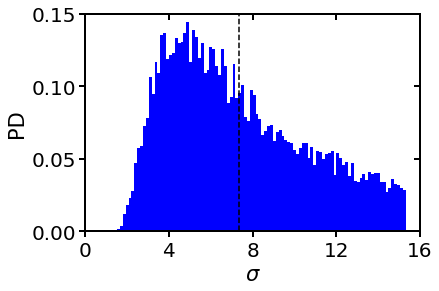

In [6]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))

bins = np.arange(8000, 152000+100, 100)
ax.hist(x=cluster_stds, bins=100, density=True, color="blue")
ax.axvline(x=mean_cluster_std, color="k", ls="--")
ax.set_xlim(0, 16)
ax.set_xlabel(r"$\sigma$", fontsize=21)
ax.set_ylabel("PD", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
num_ticks_x = 5
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks_x))
tick_spacing_y = 0.05
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
second_axis(ax, "top", num_ticks=num_ticks_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_ylim(0, 0.15)

fig.savefig(r"Figures\Figure 2\cluster_stds.svg")

### Localization precision determination via convex hull

In [7]:
lookup_table_path = r"Lookup_tables\lookup_table_area_2d.csv"
pred_sigma, num_clust = stdd.std_determination_lmfit(sample_count_vary, area_chs_vary, minimum=5, maximum=8, 
                                                     lookup_table_path=lookup_table_path)
localization_precision, num_clust_exp = stdd.std_determination_lmfit(sample_count_exp, area_chs_exp, minimum=5, 
                                                                     maximum=8, 
                                                                     lookup_table_path=lookup_table_path)
print("The mean localization precision is {:.2f}".format(mean_cluster_std))
print("The predicted localization precision of the simulation of varying precisions is {:.2f}".format(pred_sigma))
print("The predicted localization precision of the experimental data is {:.2f}".format(localization_precision))

The mean localization precision is 7.36
The predicted localization precision of the simulation of varying precisions is 8.05
The predicted localization precision of the experimental data is 7.82


## Simulate the experimental data with constant localization precision (equal to the mean of the simulated varying localization precisions)

In [8]:
sim_param = dict(parent_intensity=1e-5, lower_limit=-5300, upper_limit=5300, cluster_mu=9, 
                 cluster_std=mean_cluster_std, seed=np.random.default_rng(100), min_samples=3)

samples_const, labels_const, _ = si.sim_dstorm(**sim_param)
_, sample_count_const, area_chs_const, _ = cp.cluster_property(labels_const, samples_const)

constant_cluster_std = np.concatenate(([sample_count_const], [area_chs_const]))  # for 2D histogram

pred_sigma, num_clust = stdd.std_determination_lmfit(sample_count_const, area_chs_const, minimum=5, maximum=8, 
                                                     lookup_table_path=lookup_table_path)
print("The predicted localization precision of the simulation of constant precision is {:.2f}".format(pred_sigma))

The predicted localization precision of the simulation of constant precision is 7.43


## 2D Histograms of the area of the convex hull per n
Top left: Experimental data (CD45)\
Bottom left: Simulation with varying localization precisions\
Top right: Simulation with constant localization precision

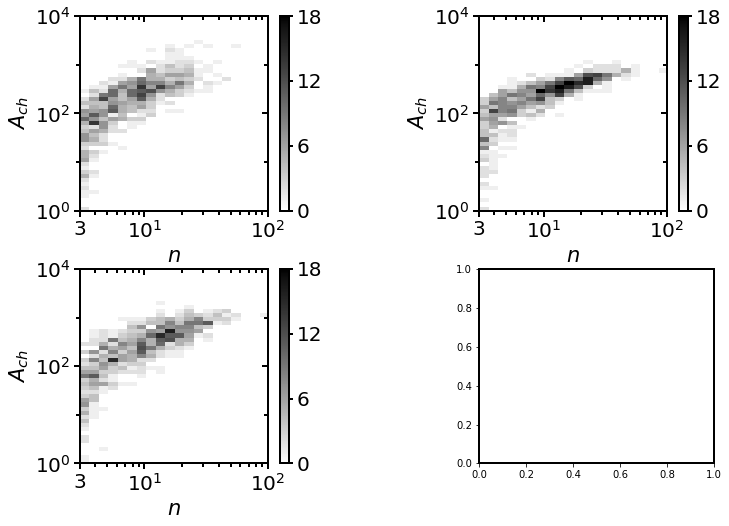

In [9]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(2, 2, figsize=(11.36, 7.1))
fig.subplots_adjust(hspace=0.3, wspace=0.7, top=1)
axes = bh.axis.AxesTuple((
    bh.axis.Regular(20, 3, 103, transform=bh.axis.transform.log),
    bh.axis.Regular(50, 1, 15000, transform=bh.axis.transform.log)
))
histogram = bh.Histogram(*axes)
y_1 = [experimental_data, varying_cluster_std, constant_cluster_std]
vmax = [18, 18, 18]
cbar_spacing = [6, 6, 6]
axeses = np.concatenate((ax[:, 0], ax[:, 1]))


for i, axis in enumerate(axeses):
    if i == 3:
        continue
    histogram.reset()
    histogram.fill(*y_1[i])
    mesh = axis.pcolormesh(*histogram.axes.edges.T, histogram.view().T, vmin=0, vmax=vmax[i], 
                           cmap=cc.m_gray.reversed(), zorder=0)
    cbar = fig.colorbar(mesh, ax=axis)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(cbar_spacing[i]))
    cbar.ax.tick_params(width=2, length=4, labelsize=20)
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_ylabel(r"$A_{ch}$", fontsize=21)
    axis.set_xlabel(r"$n$", fontsize=21)
    tick_spacing_x = 10
    axis.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
    tick_spacing_y = 100
    axis.yaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_y))
    axis.tick_params(labelsize=20, width=2, length=6)
    axis.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(1., 10.), base=10))
    axis.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
    axis.tick_params(which="minor", width=2, length=4, labelleft=False, left=True)
    second_axis_log(axis, "top", tick_spacing_x)
    second_axis_log(axis, "right", tick_spacing_y)
    axis.set_ylim(1, 1e4)
    xtick = axis.get_xticks()
    np.append(xtick, [3])
    xtick[-1] = 3
    labels = [item.get_text() for item in axis.get_xticklabels()]
    for i in range(len(xtick)):
        l = int(np.log10(xtick[i]))
        labels[i] = r"$10^{}$".format(l)
    labels[-1] = "3"
    axis.set_xticks(xtick)
    axis.set_xticklabels(labels)
    axis.set_xlim(3, 1e2)

fig.savefig(r"Figures\Figure 2\2d_histograms.svg")

## 1D Histograms of the area of the convex hull for different n
Left side: Comparison of experimental data with simulation of varying and constant localization precision.\
Due to limited clusters of experimental data of higher n, it was continued without experimental data.\
Right side: Comparison of simulation with varying and constant localization precision.\
\
Description: Clusters of varying localization precision shift increasingly to the right x-direction with increasing n. The disitribution is of larger kurtosis and therefore less normally distributed. This tail formation which already starts at low n is the reason why the localization precision prediction via convex hull can be ~5% above the true value (with the simulation parameters chosen here). In general, it depends on what n values are used for the prediction and how much the photon counts are varying (the more, the worse the prediction)).\
\
Explanation: looking at the INK distribution of the localization precision, one can see that many values are a little lower than the mean. On the other hand, some values are much higher than the mean (ratio in the here simulated case: 6 (below mean) : 4.5 (above mean)). Taking a cluster of e.g. 21 samples of constant localization precision and applying the varying localization precision: 12 samples will be closer to the center, 9 will be further away. Since the convex hull is constructed only with a subset of samples - those which lie further away from the clusters centre - it is likely that the convex hull is constructed mainly with the 9 samples further away. This leads to an increase of the area of the convex hull. 


In [10]:
sim_param = dict(parent_intensity=1e-5, lower_limit=-40000, upper_limit=40000, cluster_mu=9, 
                 cluster_std=mean_cluster_std, seed=np.random.default_rng(100), min_samples=3)

samples_const_XL, labels_const_XL, _ = si.sim_dstorm(**sim_param)
_, sample_count_const_XL, area_chs_const_XL, _ = cp.cluster_property(labels_const_XL, samples_const_XL)

sim_param = dict(parent_intensity=1e-5, lower_limit=-40000, upper_limit=40000, cluster_mu=9, min_samples=3,
                 seed=np.random.default_rng(100), gamma_a=gamma_a, photons_min=photons_min,
                 photons_mean=photons_mean, photons_background=photons_background, psf_std=psf_std, 
                 pixel_size=pixel_size)

samples_vary_XL, labels_vary_XL, _, _, _, _, _ = si.sim_std_vary(**sim_param)
_, sample_count_vary_XL, area_chs_vary_XL, _ = cp.cluster_property(labels_vary_XL, samples_vary_XL)

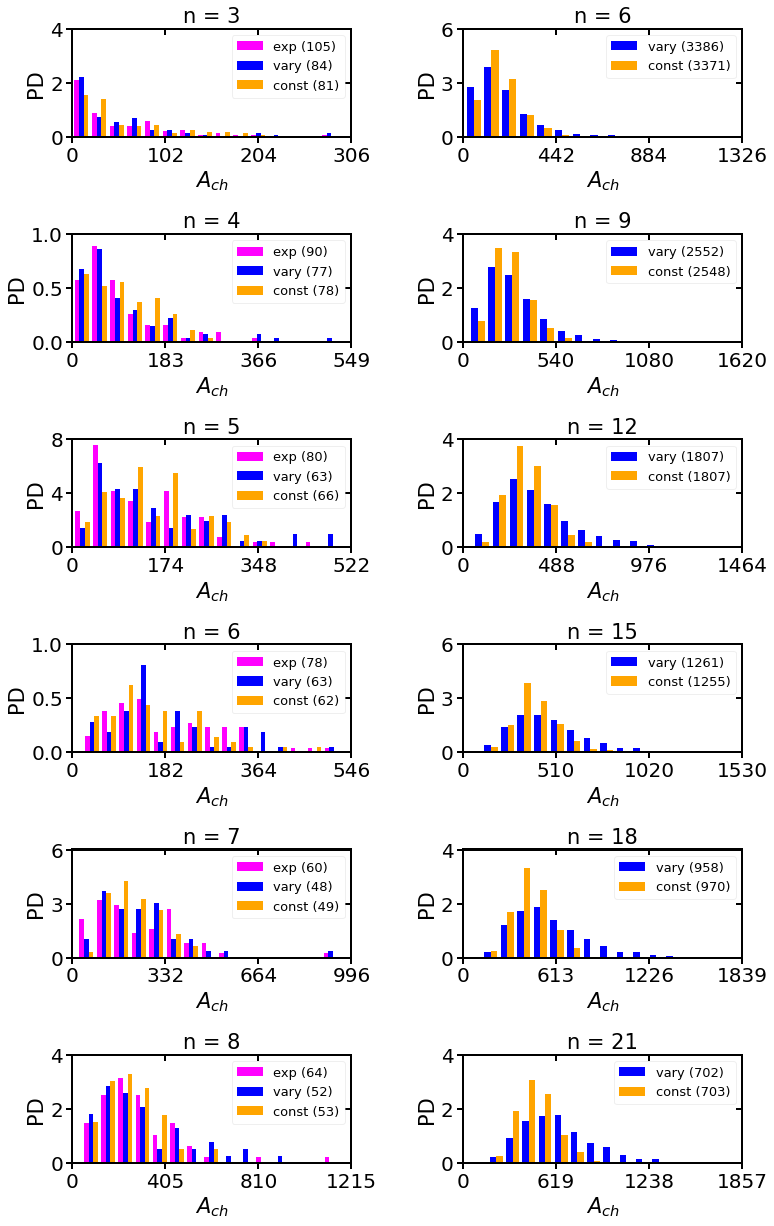

In [51]:
fig, ax = plt.subplots(6, 2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.9, wspace=0.4, top=1)
axeses = np.concatenate((ax[:, 0], ax[:, 1]))
for i, axis in enumerate(axeses):
    if i < 6:
        idx_exp = np.where(sample_count_exp==i+3)
        idx_vary = np.where(sample_count_vary==i+3)
        idx_const = np.where(sample_count_const==i+3)
        axis.hist([area_chs_exp[idx_exp], area_chs_vary[idx_vary], area_chs_const[idx_const]], bins=15, 
                  density=True, color=["magenta", "blue", "orange"], 
                  label=["exp (" + str(len(idx_exp[0])) + ")" , 
                         "vary (" + str(len(idx_vary[0])) + ")", 
                         "const (" + str(len(idx_const[0])) + ")"])
        axis.legend(loc=1, fontsize=13, framealpha=0.3)
        axis.set_title("n = " + str(i+3), fontdict=dict(fontsize=21))
    else:
        idx_vary = np.where(sample_count_vary_XL==i+((i-6)*2))
        idx_const = np.where(sample_count_const_XL==i+((i-6)*2))
        axis.hist([area_chs_vary_XL[idx_vary], area_chs_const_XL[idx_const]], bins=15, color=["blue", "orange"],
                  density=True, label=["vary (" + str(len(idx_vary[0])) + ")",
                                       "const (" + str(len(idx_const[0])) + ")"])
        axis.legend(loc=1, fontsize=13, framealpha=0.3)
        axis.set_title("n = " + str(i+((i-6)*2)), fontdict=dict(fontsize=21))
    num_ticks_x = 4
    axis.xaxis.set_major_locator(ticker.LinearLocator(num_ticks_x))
    num_ticks_y = 3
    axis.yaxis.set_major_locator(ticker.LinearLocator(num_ticks_y))
    second_axis(axis, "top", num_ticks=num_ticks_x)
    second_axis(axis, "right", num_ticks=num_ticks_y)
    axis.set_xlabel("$A_{ch}$", fontsize=21)
    axis.set_ylabel("PD", fontsize=21)
    axis.tick_params(labelsize=20, width=2, length=6)
    _, x_max = axis.get_xlim()
    x_max_new = (x_max + (num_ticks_x-1)) - (x_max % (num_ticks_x-1)) 
    axis.set_xlim(0, x_max_new)
    _, y_max = axis.get_ylim()
    axis.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
    fig.canvas.draw()  # needed to receive the updated offset text
    multiplier = axis.yaxis.get_offset_text().get_text()
    multiplier = multiplier.replace(u'\u2212', "-")
    y_max_ = y_max * (1/float(multiplier))
    y_max_new = (y_max_ + (num_ticks_y-1)) - (y_max_ % (num_ticks_y-1))
    axis.set_ylim(0, y_max_new*(float(multiplier)))
    axis.yaxis.get_offset_text().set_visible(False)

## Visualization of *d*STORM data
### TODO:
Adjust appearance

<AxesSubplot:title={'center':'counts'}, xlabel='position_x', ylabel='position_y'>

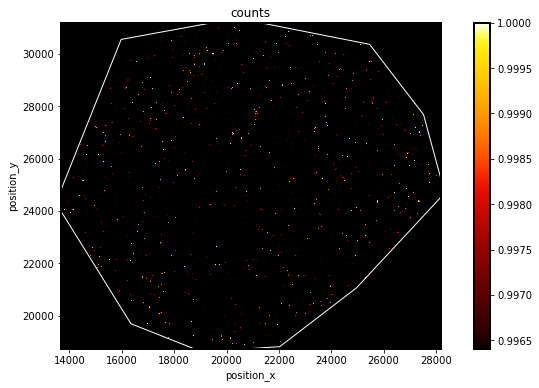

In [76]:
fig, ax = plt.subplots(figsize=(14,8))
lc.render_2d(locdata, ax=ax, bin_size=20, rescale="equal")
locdata.region.plot(ax=ax, fill=False, color="White")
